Found 252 image files in dataset
Successfully loaded 252 images
Class distribution:
  Tumor (yes): 155
  No Tumor (no): 97


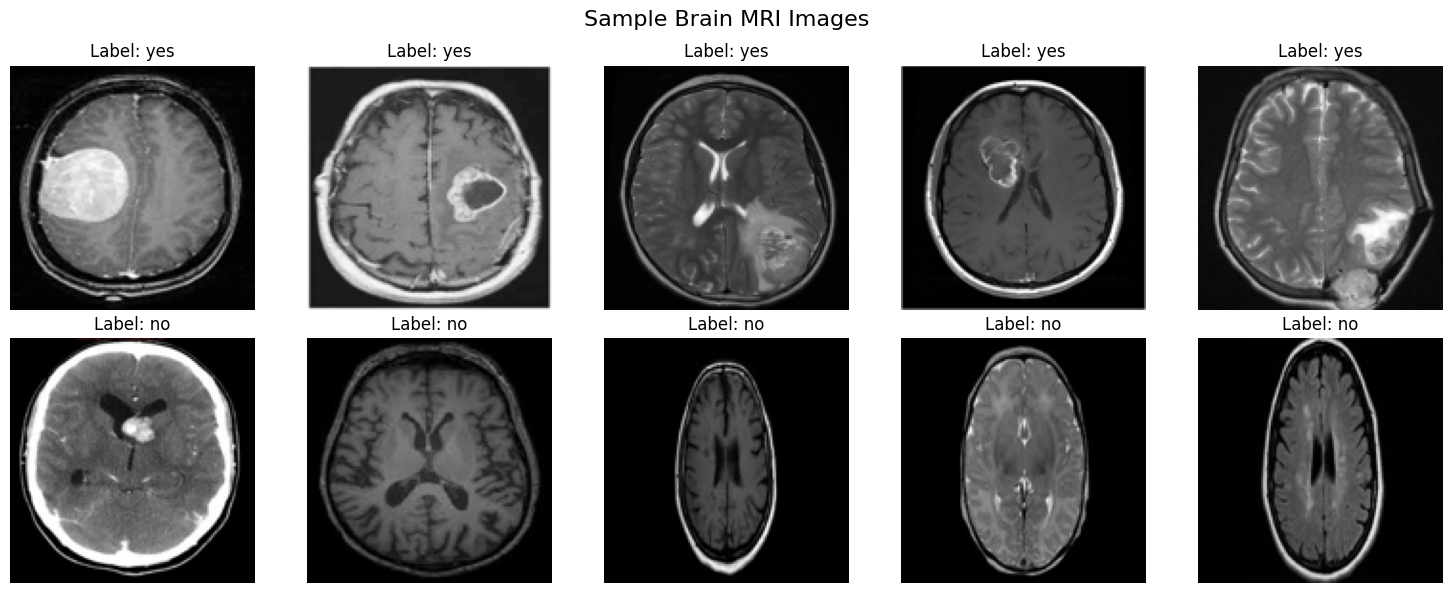

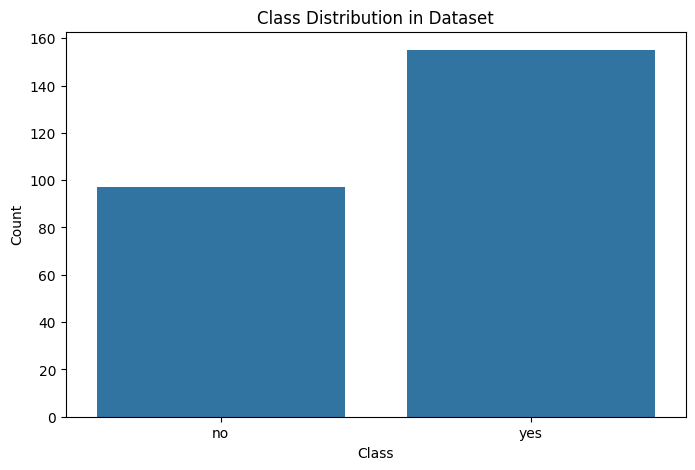

Training set size: 201
Test set size: 51
Train class distribution: [ 77 124]
Test class distribution: [20 31]
TRADITIONAL MACHINE LEARNING MODELS

Training Random Forest...
Random Forest Accuracy: 0.7843
Random Forest F1-Score: 0.8254

Training SVM...
SVM Accuracy: 0.7451
SVM F1-Score: 0.8060

Training KNN...
KNN Accuracy: 0.7255
KNN F1-Score: 0.7812

Training Gradient Boosting...


In [ ]:
# ============================================
# BRAIN TUMOR DETECTION SYSTEM (Modified - No OpenCV)
# ============================================

# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# Step 2: Data Loading and Preprocessing (Modified)
# ============================================

def load_and_preprocess_data(dataset_path, img_size=(128, 128)):
    """
    Load images from dataset folder and preprocess them using PIL
    """
    images = []
    labels = []
    
    # Get all files in the dataset folder
    all_files = [f for f in os.listdir(dataset_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    print(f"Found {len(all_files)} image files in dataset")
    
    for filename in all_files:
        img_path = os.path.join(dataset_path, filename)
        
        try:
            # Read image using PIL
            img = Image.open(img_path)
            
            # Convert to RGB if necessary
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            
            # Convert to numpy array and normalize
            img_array = np.array(img) / 255.0
            
            # Determine label based on filename
            filename_lower = filename.lower()
            
            if filename_lower.startswith(('y', 'yes')):
                label = 'yes'  # Tumor present
            elif filename_lower.startswith(('n', 'no')) or 'no' in filename_lower:
                label = 'no'   # No tumor
            else:
                # Check if it's one of the numbered images
                try:
                    # Extract numbers from filename
                    base_name = os.path.splitext(filename)[0]
                    num_part = ''.join(filter(str.isdigit, base_name))
                    if num_part:
                        # Check if it's in the "no" numbered files
                        # You might need to adjust this based on your naming convention
                        label = 'no'  # Assuming numbered files are 'no'
                    else:
                        continue  # Skip files we can't classify
                except:
                    continue
            
            images.append(img_array)
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"Successfully loaded {len(images)} images")
    print(f"Class distribution:")
    print(f"  Tumor (yes): {np.sum(labels == 'yes')}")
    print(f"  No Tumor (no): {np.sum(labels == 'no')}")
    
    return images, labels

# Load your dataset
dataset_path = "brain_tumor_dataset"  # Update this path if needed

# Check if dataset exists
if not os.path.exists(dataset_path):
    print(f"Error: Dataset folder '{dataset_path}' not found!")
    print("Please ensure:")
    print(f"1. The folder '{dataset_path}' exists in the same directory as this notebook")
    print("2. The folder contains your brain tumor images")
    # Create empty arrays for testing
    X = np.array([])
    y = np.array([])
else:
    X, y = load_and_preprocess_data(dataset_path)

# ============================================
# Step 3: Exploratory Data Analysis (EDA)
# ============================================

def plot_sample_images(images, labels, num_samples=10):
    """
    Plot sample images from the dataset
    """
    if len(images) == 0:
        print("No images to display")
        return
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Get indices for yes and no classes
    yes_indices = np.where(y == 'yes')[0]
    no_indices = np.where(y == 'no')[0]
    
    # Sample equal from both classes
    indices = list(yes_indices[:5]) + list(no_indices[:5])
    
    for i, idx in enumerate(indices[:10]):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis('off')
    
    plt.suptitle("Sample Brain MRI Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot sample images if data is loaded
if len(X) > 0:
    plot_sample_images(X, y)
    
    # Plot class distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    
    # ============================================
    # Step 4: Data Preparation
    # ============================================
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # 0 for no, 1 for yes
    
    # Split data into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    # For traditional ML models, we need to flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # For CNN models, we keep the image shape
    X_train_cnn = X_train
    X_test_cnn = X_test
    
    # ============================================
    # Step 5: Traditional Machine Learning Models
    # ============================================
    
    def train_evaluate_ml_models(X_train, X_test, y_train, y_test):
        """
        Train and evaluate multiple ML models
        """
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', probability=True, random_state=42),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Naive Bayes': GaussianNB()
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1_score': report['1']['f1-score'],
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"{name} Accuracy: {accuracy:.4f}")
            print(f"{name} F1-Score: {results[name]['f1_score']:.4f}")
        
        return results
    
    # Train and evaluate ML models
    print("=" * 50)
    print("TRADITIONAL MACHINE LEARNING MODELS")
    print("=" * 50)
    ml_results = train_evaluate_ml_models(X_train_flat, X_test_flat, y_train, y_test)
    
    # ============================================
    # Step 6: Deep Learning Models (CNN)
    # ============================================
    
    def create_simple_cnn(input_shape=(128, 128, 3)):
        """
        Create a simple CNN model
        """
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        
        return model
    
    def create_vgg16_transfer_learning(input_shape=(128, 128, 3)):
        """
        Create a model using VGG16 transfer learning
        """
        # Load pre-trained VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        
        # Freeze the base model
        base_model.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        
        return model
    
    def train_cnn_model(model, X_train, y_train, X_test, y_test, model_name, epochs=20, batch_size=32):
        """
        Train and evaluate a CNN model
        """
        print(f"\nTraining {model_name}...")
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
        ]
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate the model
        test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
        
        # Make predictions
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate F1 score
        from sklearn.metrics import f1_score
        f1 = f1_score(y_test, y_pred)
        
        results = {
            'model': model,
            'history': history,
            'accuracy': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': f1,
            'y_pred': y_pred.flatten(),
            'y_pred_proba': y_pred_proba.flatten()
        }
        
        print(f"{model_name} Accuracy: {test_acc:.4f}")
        print(f"{model_name} F1-Score: {f1:.4f}")
        
        return results
    
    # Train CNN models
    print("\n" + "=" * 50)
    print("DEEP LEARNING MODELS (CNN)")
    print("=" * 50)
    
    # Create and train models
    simple_cnn = create_simple_cnn()
    vgg16_model = create_vgg16_transfer_learning()
    
    # Train models
    cnn_results = {}
    cnn_results['Simple CNN'] = train_cnn_model(simple_cnn, X_train_cnn, y_train, X_test_cnn, y_test, "Simple CNN", epochs=30)
    cnn_results['VGG16'] = train_cnn_model(vgg16_model, X_train_cnn, y_train, X_test_cnn, y_test, "VGG16", epochs=20)
    
    # ============================================
    # Step 7: Model Comparison and Evaluation
    # ============================================
    
    def plot_model_comparison(ml_results, cnn_results):
        """
        Plot comparison of all models
        """
        # Combine results
        all_results = {}
        all_results.update(ml_results)
        all_results.update(cnn_results)
        
        # Create comparison dataframe
        comparison_data = []
        for name, result in all_results.items():
            comparison_data.append({
                'Model': name,
                'Accuracy': result['accuracy'],
                'F1-Score': result['f1_score'],
                'Precision': result.get('precision', 0),
                'Recall': result.get('recall', 0)
            })
        
        df_comparison = pd.DataFrame(comparison_data)
        
        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Accuracy comparison
        axes[0, 0].barh(df_comparison['Model'], df_comparison['Accuracy'])
        axes[0, 0].set_xlabel('Accuracy')
        axes[0, 0].set_title('Model Accuracy Comparison')
        axes[0, 0].axvline(x=df_comparison['Accuracy'].max(), color='r', linestyle='--', alpha=0.5)
        
        # F1-Score comparison
        axes[0, 1].barh(df_comparison['Model'], df_comparison['F1-Score'])
        axes[0, 1].set_xlabel('F1-Score')
        axes[0, 1].set_title('Model F1-Score Comparison')
        axes[0, 1].axvline(x=df_comparison['F1-Score'].max(), color='r', linestyle='--', alpha=0.5)
        
        # Precision-Recall comparison
        axes[1, 0].scatter(df_comparison['Recall'], df_comparison['Precision'])
        for i, row in df_comparison.iterrows():
            axes[1, 0].annotate(row['Model'], (row['Recall'], row['Precision']))
        axes[1, 0].set_xlabel('Recall')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title('Precision-Recall Tradeoff')
        axes[1, 0].grid(True)
        
        # Detailed metrics bar plot
        df_melted = df_comparison.melt(id_vars=['Model'], value_vars=['Accuracy', 'F1-Score', 'Precision', 'Recall'],
                                       var_name='Metric', value_name='Value')
        sns.barplot(data=df_melted, x='Value', y='Model', hue='Metric', ax=axes[1, 1])
        axes[1, 1].set_title('Detailed Model Metrics')
        axes[1, 1].set_xlabel('Score')
        
        plt.tight_layout()
        plt.show()
        
        return df_comparison
    
    # Plot model comparison
    print("\n" + "=" * 50)
    print("MODEL COMPARISON")
    print("=" * 50)
    df_comparison = plot_model_comparison(ml_results, cnn_results)
    
    # Display comparison table
    print("\nModel Performance Comparison:")
    print(df_comparison.sort_values('Accuracy', ascending=False).to_string(index=False))
    
    # Find best model
    best_model_name = df_comparison.loc[df_comparison['Accuracy'].idxmax(), 'Model']
    best_model_accuracy = df_comparison['Accuracy'].max()
    print(f"\n{'='*50}")
    print(f"BEST MODEL: {best_model_name} with Accuracy: {best_model_accuracy:.4f}")
    print('='*50)
    
    # ============================================
    # Step 8: Confusion Matrix for Best Model
    # ============================================
    
    def plot_confusion_matrix_for_best_model(best_model_name, ml_results, cnn_results, y_test, label_encoder):
        """
        Plot confusion matrix for the best model
        """
        # Get best model results
        if best_model_name in ml_results:
            best_result = ml_results[best_model_name]
        else:
            best_result = cnn_results[best_model_name]
        
        y_pred = best_result['y_pred']
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print classification report
        print(f"\nClassification Report for {best_model_name}:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Plot confusion matrix for best model
    plot_confusion_matrix_for_best_model(best_model_name, ml_results, cnn_results, y_test, label_encoder)
    
    # ============================================
    # Step 9: Save Best Model
    # ============================================
    
    def save_best_model(best_model_name, ml_results, cnn_results):
        import joblib as jb
        """
        Save the best model for future use
        """
        # Get best model
        if best_model_name in ml_results:
            best_model = ml_results[best_model_name]['model']
            # Save sklearn model
            
            jb.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
            print(f"Saved {best_model_name} as 'best_model_{best_model_name.replace(' ', '_')}.pkl'")
        else:
            best_model = cnn_results[best_model_name]['model']
            # Save keras model
            best_model.save(f'best_model_{best_model_name.replace(" ", "_")}.h5')
            print(f"Saved {best_model_name} as 'best_model_{best_model_name.replace(' ', '_')}.h5'")
        
        # Save label encoder
        jb.dump(label_encoder, 'label_encoder.pkl')
        print("Saved label encoder as 'label_encoder.pkl'")
    
    # Save best model
    save_best_model(best_model_name, ml_results, cnn_results)
    
    print("\n" + "=" * 50)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("=" * 50)

else:
    print("\nNo data loaded. Please check your dataset folder and try again.")

In [ ]:
!pip install seaborn


In [ ]:
!pip install tensorflow
